In [57]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from torchmetrics import functional as FM
    

In [59]:

class MnistClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def validation_setp(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = FM.accruacy(logits, y)
        loss = F.cross_entropy(logits, y)
        metrics = {'val_acc': acc, 'val_loss': loss}
        self.log_dict(metrics)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        acc = FM.accuracy(logits, y)
        loss = F.cross_entropy(logits, y)
        metrics = {'test_acc': acc, 'test_loss': loss}
        self.log_dict(metrics)

In [49]:
pl.seed_everything(42)

Global seed set to 42


42

In [51]:
dataset = MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])
test = MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

In [62]:
model = MnistClassifier()
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
trainer.fit(model, DataLoader(train, batch_size=1024), DataLoader(val, batch_size=1024))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\pythonenv\mlenv\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:131: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 55.3 K
-------------------------------------
55.3 K    Trainable params
0         Non-trainable params
55.3 K    Total params
0.221     Total estimated model params size (MB)


Testing: 0it [00:59, ?it/s]/54 [00:00<?, ?it/s] 
Testing: 0it [00:32, ?it/s]
Epoch 0:   2%|▏         | 1/54 [00:00<00:06,  8.13it/s, loss=2.38, v_num=18]

d:\pythonenv\mlenv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [09:44, ?it/s]1/54 [00:01<00:04,  8.94it/s, loss=0.484, v_num=18]
Epoch 9: 100%|██████████| 54/54 [00:05<00:00, 10.01it/s, loss=0.0391, v_num=18]


In [63]:
trainer.test(dataloaders=DataLoader(test, batch_size=256))

Restoring states from the checkpoint path at c:\Users\lijm1\Desktop\Pytorch-Lightning-practice\lightning_logs\version_18\checkpoints\epoch=9-step=540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\lijm1\Desktop\Pytorch-Lightning-practice\lightning_logs\version_18\checkpoints\epoch=9-step=540.ckpt


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 32.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9714999794960022
        test_loss           0.09274710714817047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9714999794960022, 'test_loss': 0.09274710714817047}]

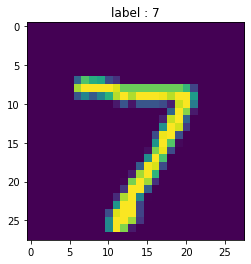

In [79]:
import matplotlib.pyplot as plt
plt.title("label : " + str(test[0][1]))
plt.imshow(test[0][0][0])

In [86]:
_, argmax = torch.max(model(test[0][0][0].unsqueeze(dim=0)), 1)

In [87]:
argmax.item()

7